# DetectingPositioningErrorsandEstimating CorrectPositionsbyMovingWindow 논문 함수 구현

논문 제목 : DetectingPositioningErrorsandEstimating CorrectPositionsbyMovingWindow<br>
논문 작성자 : HaYoonSong*,JunSeokLee<br>
작성자 출신: DepartmentofComputerEngineering,HongikUniversity,Seoul,Korea<br>
가공자: JaeeunKil<br>

## 목차

* main 함수 전개도 
* import 항목
* 최종 함수의 구현
* 데이터 양상 그리기 
* 오차 찾기

## main 함수 전개도 

In [3]:

# def main():
#     try:
#         data = [] 
#         data = load_and_delete_same_timestamp() # 데이터를 받고 같은 timestamp 지우기
#         data = append_velocity(data) # 데이터에서 원하는 데이터값 추가( 속도, 가속도 등)
#         data =publish(data) # 오차 추정 및  보정값 만들기
#         return data
#     except ValueError: # 잘못된 값이 들어올 경우
#         print(ValueError)
        
        

In [13]:
# ! pip install matplotlib

# import

In [14]:
import time
from datetime import datetime
import os
import gpxpy
import gpxpy.gpx
import math
import numbers
import geoutils
import json # import json module
import matplotlib.pyplot as plt
from numpy.lib.scimath import logn
from math import e
import json

from collections import OrderedDict

## Haversine fomula를 이용하여 거리를 구해보자

# * 설명
위도 경도를 활용하여  두 지점 사이의 거리를 구하는 함수<br>
longitude, latitude 순으로  파라미터를 작성해야한다.

In [15]:
#euclidean.py
import numbers
import math

class GeoUtil:
    """
    Geographical Utils
    """
    @staticmethod
    def degree2radius(degree):
        return degree * (math.pi/180)
    
    @staticmethod
    def get_harversion_distance(x1, y1, x2, y2, round_decimal_digits=5):  #롱랭롱랭
        """
        경위도 (x1,y1)과 (x2,y2) 점의 거리를 반환
        Harversion Formula 이용하여 2개의 경위도간 거래를 구함(단위:Km)
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
  
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        R = 6371 # 지구의 반경(단위: km)
        dLon = GeoUtil.degree2radius(x2-x1)    
        dLat = GeoUtil.degree2radius(y2-y1)

        a = math.sin(dLat/2) * math.sin(dLat/2) \
            + (math.cos(GeoUtil.degree2radius(y1)) \
              *math.cos(GeoUtil.degree2radius(y2)) \
              *math.sin(dLon/2) * math.sin(dLon/2))
        b = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        return round(R * b, round_decimal_digits)

    @staticmethod
    def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
        """
        유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
        """
        if x1 is None or y1 is None or x2 is None or y2 is None:
            return None
        assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
        assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
        assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
        assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

        dLon = abs(x2-x1) # 경도 차이
        if dLon >= 180:   # 반대편으로 갈 수 있는 경우
            dLon -= 360   # 반대편 각을 구한다
        dLat = y2-y1      # 위도 차이
        return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)

# 거리구하는 함수

In [16]:
def distance(x1, y1, x2, y2):
    #distance = math.sqrt((x1-x2)**2 + (y1-y2)**2) # 논문에서 간단한 거릴떄는 피타고라스 사용 가을하다고 함
    distance=GeoUtil.get_harversion_distance(x1, y1, x2, y2)
    return distance

# 파일 넣으면 해당 파일에 있는 gpx데이터 리스트 반환

* json 형식으로 받았습니다.
* timestamp 순 정렬 후,  같은 timestamp 인 데이터는 오류를 피하기 위해 삭제함

In [17]:
def load_and_delete_same_timestamp():
    gpxes = []
    
    with open('gpx.json', encoding='utf-8') as fh:
        data = json.load(fh) 
        gpxes=data 
        gpxes = sorted(data, key=lambda k: k['timestamp']) 
        
        len_gpx_1=len(gpxes)-1
        last_param=gpxes[len_gpx_1]['timestamp']
        gpx_param=0
        while(1):
            if gpxes[gpx_param]['timestamp']!=last_param:
                if gpxes[gpx_param]['timestamp']==gpxes[gpx_param+1]['timestamp']:
                    gpxes=gpxes[:gpx_param]+gpxes[gpx_param+1:]
                    len_gpx_1=len_gpx_1-1
                    #print(gpx_param) # timestamp same error index print
                    gpx_param=gpx_param-1
                gpx_param=1+gpx_param
            else:
                break
            

    return gpxes  # 추출한 gpx정보 리턴

load_and_delete_same_timestamp() # 실행 예시
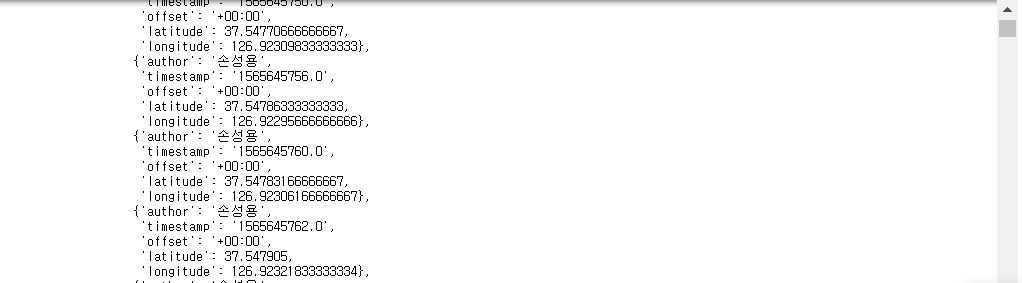

# gpx 데이터 가공
### 각각의 속도 filtered 열 첨가
corrected 값은 바뀔 예정이지만 형식의 용이를 위해 origin과 같은 값으로 미리 삽입해 놓는다


### 인자에 대한 설명

기본적으로 origin 이라는 값이 붙여있거나 일반 인자의 경우 조작변인, <br>
corrected 가 붙어있을 경우 종속 변인으로 잡았습니다. <br>
corrected 인자들의 default 값을 origin 값들로 주어,  최종 결과는 corrected 로 확인하시는 것이 좋습니다.

In [18]:
# 데이터 형식{'datetime': '2019-08-16 09:00:31', 'timestamp': 1565913631.0, 'latitude': 37.55016333333333, 'longitude': 126.92437333333334}, {'datetime': '2019-08-16 09:00:32', 'timestamp': 1565913632.0, 'latitude': 37.55007, 'longitude': 126.92435833333333},

In [19]:
def append_velocity(data):
    #0번째 데이터에는 속도 0으로 넣을것
    data_len=len(data)
    
    data[0]["timestamp"]=float(data[0]["timestamp"]) # float 으로 형변환
    
    data[0]['originalV']=0 #측정값 속력
    data[0]['correctedV']=0 #교정값 속력
    data[0]['aCorrected']=0 #가속도 정정
    data[0]['a']=0 #가속도
    
    data[0]['Vlongti']=0 #longtitude  속력
    data[0]['Vlati']=0 #latitude  속력 
    
    data[0]['filtered']='false' # 이동창 가공 되야하는 친구(가공 되야 하면 true)
    data[0]['accelFiltered']='false' # 가속도 가공 되야하는 친구(가공 되야 하면 true)
    data[0]['retrieved']='false' # 이동창 교정 not 가속도 교정
    data[0]['interpolated']='false' #이동창  교정  가속도 교정
    
    
    data[0]['latitudeCorrected']= data[0]['latitude'] # 정정 latitude
    data[0]['longitudeCorrected']= data[0]['longitude']  # 정정 longitude
    

    for param in range(1,data_len): 
       
       
            
        data[param]["timestamp"]=float(data[param]["timestamp"])
        if data[param-1]["timestamp"] < data[param]["timestamp"]:
            t=data[param]["timestamp"]- data[param-1]["timestamp"]
            
            data[param]['filtered']='false'
            data[param]['accelFiltered']='false'
            data[param]['retrieved']='false'
            data[param]['interpolated']='false' # 속력 교정 not 가속도 교정
            data[param]['latitudeCorrected']= data[param]['latitude']
            data[param]['longitudeCorrected']= data[param]['longitude']
            dist_01=distance( data[param]["longitude"],data[param]["latitude"], data[param-1]["longitude"], data[param-1]["latitude"])
       
            data[param]['originalV']=dist_01/ t
            data[param]['Vlongti']= abs(data[param]["longitude"]-data[param-1]["longitude"])/t
            data[param]['Vlati']=abs(data[param]["latitude"]-data[param-1]["latitude"])/t
            data[param]['correctedV']=data[param]['originalV']
            if(param)==1:
                data[param]['a']=0
                data[param]['aCorrected']=0
            else:
                data[param]['a']=(data[param]['originalV']-data[param-1]['originalV'])/t
                data[param]['aCorrected']=data[param]['a']
        else: #timestamp 같은 경우
            pass
        
    return data

In [20]:
ex=[{'datetime': '2019-08-16 09:00:31', 'timestamp': 1565913631.0, 'latitude': 37.55016333333333, 'longitude': 126.92437333333334}, {'datetime': '2019-08-16 09:00:32', 'timestamp': 1565913632.0, 'latitude': 37.55007, 'longitude': 126.92435833333333}]

In [21]:
append_velocity(ex)

[{'datetime': '2019-08-16 09:00:31',
  'timestamp': 1565913631.0,
  'latitude': 37.55016333333333,
  'longitude': 126.92437333333334,
  'originalV': 0,
  'correctedV': 0,
  'aCorrected': 0,
  'a': 0,
  'Vlongti': 0,
  'Vlati': 0,
  'filtered': 'false',
  'accelFiltered': 'false',
  'retrieved': 'false',
  'interpolated': 'false',
  'latitudeCorrected': 37.55016333333333,
  'longitudeCorrected': 126.92437333333334},
 {'datetime': '2019-08-16 09:00:32',
  'timestamp': 1565913632.0,
  'latitude': 37.55007,
  'longitude': 126.92435833333333,
  'filtered': 'false',
  'accelFiltered': 'false',
  'retrieved': 'false',
  'interpolated': 'false',
  'latitudeCorrected': 37.55007,
  'longitudeCorrected': 126.92435833333333,
  'originalV': 0.01046,
  'Vlongti': 1.5000000004761205e-05,
  'Vlati': 9.333333333216842e-05,
  'correctedV': 0.01046,
  'a': 0,
  'aCorrected': 0}]

## sign함수

sign(x) 에서 x 가 0 보다 크면 1, 0이면 0, 0보다 작으면 -1 반환

In [22]:
def sign(x):
    if x>0:
        return 1
    elif x==0:
        return 0
    else:
        return -1
    

# MSD MA계산
* 이 논문에서는 정의만 나와있고, 계산법이 자세히 나와 있지 않습니다. 그래서  아래 논문을 참고하였습니다.

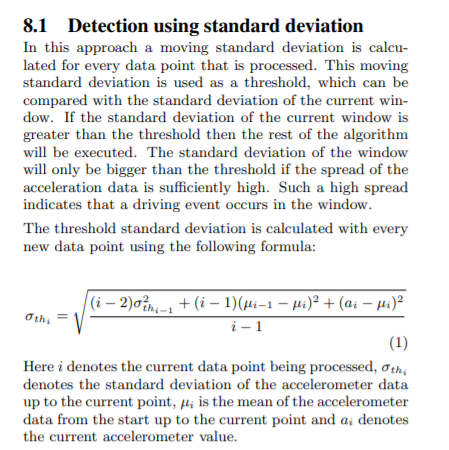


참고 논문 https://pdfs.semanticscholar.org/7387/97b60eeb5a145c76566c5c44db8b17d38867.pdf

# 구현 그 자체

In [23]:
OVERFLOW=999 # 0이 분모로 되는 값에  최대 number 

def publish(data, parameter):

     #Initial Window Size 
    IWS = parameter['IWS']
    #Maximum Window Size, IWS <= MWS
    MWS = parameter['MWS']
    #min speed
    MINSPEED = parameter['MINSPEED']
    print(MINSPEED)
    #max acceleration
    MAXaccel= parameter['MAXaccel']
    #error tolerance of distantce
    ET =parameter['ET']
    #user SL s
    SL=parameter['SL']
    
    n = IWS
    #moving average
    MA = 0
    
    #moving standard deviation
    MSD = 0
    
    
    
    ''' The minimumspeed, MINspeed, for ouralgorithm is the maximum speed determined by ETD 
    and MINSPEED, which are user-defined parameters, andboth are required for theexecutionof ouralgorithm.'''

   
    
   
    # 이 논문에서 1.0 2.0 
    
    #loop
    i = 0 
    
    #  Maximum possible velocity in user SL s 
    # calculate LP(Location Parameter)
    LP=0
    
    #Number of Consecutive Errors
    NCE = 0 # 오류 정정 횟수
    
    # velocity for checking whether Vi +1is to be calibrated
    Vcalib=0 
    # moving average
    MA = 0
    
    # moving average for latitude, longitude
    MAlati=0
    MAlongti=0
    
    # moving standard deviation
    MSD = 0
    
    
    # caculate all attribute
    for i in range(len(data)-1):
        try: # 같은 timestamp 시 에러 발생
            MINSPEED = min(ET/(data[i+1]["timestamp"] - data[i]["timestamp"]), MINSPEED)
        except:
            print('same timestamp between data code:'+str(i+1))
            return
        
        
        if i > n: # 우리는 i 번째를 따지는 거죠
            MAlati=abs(data[i-n-1]["latitude"]-data[i]["latitude"])/n
            MAlongti=abs(data[i-n-1]["longitude"]-data[i]["longitude"])/n
            MAbefore=MA # 계산의 용이를 위한 인자
            
            MA = distance(data[i-n-1]["longitude"],data[i-n-1]["latitude"],  data[i]["longitude"], data[i]["latitude"]) / n
            
            if(i>2):
                MSDbunja=(i-2)*MSD**2+(i-1)*(MAbefore-MA)**2+(data[i]['a']-MA)**2
            else:
               MSDbunja=0
            
            try:
               MSD=math.sqrt(MSDbunja/(i-1))
            except:
                MSD=OVERFLOW
        else: # 여기
                pass
            
        # calculate LP(Location Parameter)
        LP=MA-MSD
        #print("MA:"+str(MA))
        #print("MSD: "+str(MSD))
        try:
            Vori=distance( data[i-1]["longitude"],data[i-1]["latitude"], data[i]["longitude"], data[i]["latitude"]) / (data[i-1]["timestamp"]- data[i]["timestamp"])
        
        except:
            Vori=0



        #caculate Verr( Compute Maximum possible velocity in user SL s )
        # Verr:: 유저 s 가 가능한 최대 속도 계산
        molecular=1-SL # 분자
        try:
            param=1/MSD
        except:
            param=OVERFLOW

        denominator=math.exp(-param)
        try:
            Verr   = ( molecular/denominator )+LP
        except:
            Verr=OVERFLOW
        

        VcalibBunmo=logn(e,0.005)*MSD
        if VcalibBunmo==0:
            Vcalib=OVERFLOW
        else:
            Vcalib=(-1/(VcalibBunmo))+LP
        
        # 이동창 크기 조정
        if((data[i+1]["originalV"]>Verr) or (data[i+1]["a"]>=MAXaccel))and (data[i+1]["originalV"]>MINSPEED):
                data[i+1]["filtered"]='true'
                NCE=NCE+1 # 오류 정정 횟수
                if(n+1>MWS):
                    n=MWS
                else:
                     n=n+1  # Window Size Adjustment-Increase 
        else: #1
            NCE=0  # 오류 정정 횟수
            if(n-1<IWS):
                    n=IWS
            else:
                     n=n-1  # Window Size Adjustment-Decrease
                    
                    
                    
        #오류 탐지
        
        # 오류 사항 1번: 다음 측정된 속도가 교정 속도보다 크고, 가능한 최대 다음 측정된 속도가  MINSPEED 보다 크다.
        if (data[i+1]["originalV"]>=Vcalib) and (data[i+1]["originalV"]> MINSPEED):
            data[i+1]["correctedV"]= Vcalib # Calibration of Speed
            print('오류 사항 1번: 다음 측정된 속도가 교정 속도보다 크고, 가능한 최대 다음 측정된 속도가  MINSPEED 보다 크다.')
            
        # 오류 사항 2번:     MAXaccel 초과
        if(data[i+1]["a"]>=MAXaccel):
            data[i+1]['accelFiltered']='true' # Restriction by the Maximum 
            data[i+1]["aCorrected"]=MAXaccel
            data[i+1]["correctedV"]=MA
            print(' 오류 사항 2번:  MAXaccel 초과')
            time_between_10=data[i+1]['timestamp']-data[i]['timestamp']
            data[i+1]['latitudeCorrected']=data[i+1]['latitude']+sign(data[i+1]['latitude']-data[i]['latitude'])*MAlati*time_between
            data[i+1]['longitudeCorrected']=data[i+1]['longitude']+sign(data[i+1]['longitude']-data[i]['longitude'])*MAlongti*time_between
       
        
        # 정정사항 01: 이동창 크기 조정 됐고 MAXaccel 초과 안함
        if(data[i]["originalV"]<=Verr)and(data[i]["filtered"]=="true")and(data[i]["accelFiltered"]=="false"):
            print('정정사항 01: 이동창 크기 조정 됐고 MAXaccel 초과 안함')
            data[i]['retrieved']='true'
            data[i]['correctedV']=data[i]['originalV']
            data[i]['latitudeCorrected']= data[i]['latitude']
            data[i]['longitudeCorrected']= data[i]['longitude']# Backtracking: Look back one step and Restore with original values 
            NCE=0
            if(n-1<IWS):
                    n=IWS
            else: #2
                     n=n-1  # Window Size Adjustment-Decrease
        
        # 정정사항 02: 이동창 크기 조정 됐고 MAXaccel 초과 ::덧붙여짐을 참값으로
        if(data[i]["filtered"]=="true")or(data[i]["accelFiltered"]=="true"):
            print('정정사항 02: 이동창 크기 조정 됐고 MAXaccel 초과 ::덧붙여짐을 참값으로')
            time_between_11=data[i+1]['timestamp']-data[i-1]['timestamp']
            time_between_01=data[i]['timestamp']-data[i-1]['timestamp']
            data[i]['correctedV']=(data[i+1]['correctedV']-data[i-1]['correctedV'])*time_between_01/time_between_11+data[i-1]['correctedV']
           
            # Estimation of speed
            data[i]['latitudeCorrected']= (data[i+1]['latitudeCorrected']-data[i-1]['latitudeCorrected'])*time_between_01/time_between_11+data[i-1]['latitudeCorrected']
            data[i]['longitudeCorrected']= (data[i+1]['longitudeCorrected']-data[i-1]['longitudeCorrected'])*time_between_01/time_between_11+data[i-1]['longitudeCorrected']
            # Estimation of Position
            data[i]['interpolated']='true' # 덧붙여짐을 참값으로
    print('*')
    return data


## 변수 json load

In [24]:
with open('default_args.json', 'r', encoding="utf-8") as read_file:
    parameter=json.load(read_file)
   

# main

In [25]:
 

def main():
    # 논문 parameter default
    parameter={
    "IWS":5,
    "MWS":10,
    "MINSPEED":0.00,
    "MAXaccel":10.8,
    "ET":1.0,
    "SL":0.95
    }
    # json load
#     try:
#         with open('default_args.json', 'r', encoding="utf-8") as read_file:
#             parameter=json.load(read_file)
#     except:
#         pass
    try:
        data = []
        data = load_and_delete_same_timestamp()
        data = append_velocity(data)
        
        data =publish(data, parameter)
       
        return data
    except ValueError:
        print(ValueError)
        
        

In [26]:
if __name__ == "__main__":
    answer=main()


0.0
오류 사항 1번: 다음 측정된 속도가 교정 속도보다 크고, 가능한 최대 다음 측정된 속도가  MINSPEED 보다 크다.
정정사항 01: 이동창 크기 조정 됐고 MAXaccel 초과 안함
정정사항 02: 이동창 크기 조정 됐고 MAXaccel 초과 ::덧붙여짐을 참값으로
*


In [27]:
real_answer=main()

0.0
오류 사항 1번: 다음 측정된 속도가 교정 속도보다 크고, 가능한 최대 다음 측정된 속도가  MINSPEED 보다 크다.
정정사항 01: 이동창 크기 조정 됐고 MAXaccel 초과 안함
정정사항 02: 이동창 크기 조정 됐고 MAXaccel 초과 ::덧붙여짐을 참값으로
*


# 결과를 그려보자

In [28]:
%matplotlib inline
data=main()

print(data)

0.0
오류 사항 1번: 다음 측정된 속도가 교정 속도보다 크고, 가능한 최대 다음 측정된 속도가  MINSPEED 보다 크다.
정정사항 01: 이동창 크기 조정 됐고 MAXaccel 초과 안함
정정사항 02: 이동창 크기 조정 됐고 MAXaccel 초과 ::덧붙여짐을 참값으로
*
[{'author': '손성용', 'timestamp': 1565645386.0, 'offset': '+00:00', 'latitude': 37.548008333333335, 'longitude': 126.941815, 'originalV': 0, 'correctedV': 0, 'aCorrected': 0, 'a': 0, 'Vlongti': 0, 'Vlati': 0, 'filtered': 'false', 'accelFiltered': 'false', 'retrieved': 'false', 'interpolated': 'false', 'latitudeCorrected': 37.548008333333335, 'longitudeCorrected': 126.941815}, {'author': '손성용', 'timestamp': 1565645619.0, 'offset': '+00:00', 'latitude': 37.54770333333333, 'longitude': 126.923035, 'filtered': 'false', 'accelFiltered': 'false', 'retrieved': 'false', 'interpolated': 'false', 'latitudeCorrected': 37.54770333333333, 'longitudeCorrected': 126.923035, 'originalV': 0.007107296137339056, 'Vlongti': 8.060085836912738e-05, 'Vlati': 1.3090128755555392e-06, 'correctedV': 0.007107296137339056, 'a': 0, 'aCorrected': 0}, {'author': '

In [43]:
import folium

m=folium.Map(location = [37.54915666666667,126.92376333333333],zoom_start=15) # 지도 확대

le = len(data)
for i in range(1,le):
    a = data[i]['latitude']
    b = data[i]['longitude']
    c = data[i]['latitudeCorrected']
    d = data[i]['longitudeCorrected']
    pp = [a,b]
    zz = [c,d]

    folium.Circle(pp,radius=5,color='#ABF200',fill=True, fill_color='#ABF200').add_to(m)

    folium.Circle(zz,radius=7,color='#FF0000',fill=True, fill_color='#FF0000').add_to(m)
    
m

In [30]:
show_lati=[] #  origin latitude 만 뭉친 리스트 
for kk in range(len(data)):
   show_lati.append(data[kk]['latitude'])


show_longti=[] # origin  longitude 만 뭉친 리스트 
for kk in range(len(data)):
   show_longti.append(data[kk]['longitude'])


# 

show_lati_correct=[]
for kk in range(len(data)):
   show_lati_correct.append(data[kk]['latitudeCorrected'])
show_longti_correct=[]
for kk in range(len(data)):
   show_longti_correct.append(data[kk]['longitudeCorrected'])

    data[0]['originalV']=0 #측정값 속력
    data[0]['correctedV']=0 #교정값 속력
    data[0]['Vlongti']=0 #longtitude  속력
    data[0]['Vlati']=0 #latitude  속력 
    data[0]['filtered']='false' #가공 되야하는 친구(가공 되야 하면 true)
    data[0]['accelFiltered']='false' #속도가공 되야하는 친구(가공 되야 하면 true)
    data[0]['retrieved']='false' # 속력 교정 not 가속도 교정
    data[0]['interpolated']='false' # 속력 교정 not 가속도 교정
    data[0]['a']=0 #가속도
    data[0]['latitudeCorrected']= data[0]['latitude']
    data[0]['longitudeCorrected']= data[0]['longitude']
    data[0]["timestamp"]=float(data[0]["timestamp"])

# 변경 전 위치

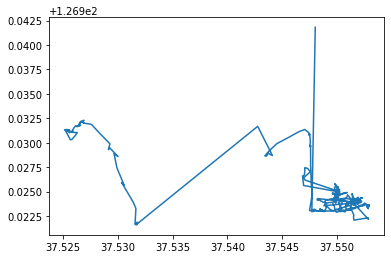

In [31]:
%matplotlib inline
plt.plot( show_lati, show_longti)



# 변경 후 위치

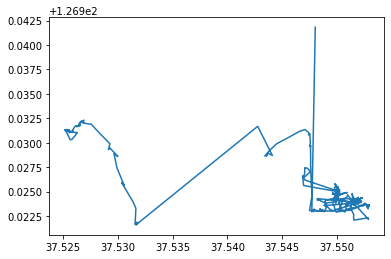

In [32]:
plt.plot( show_lati_correct, show_longti_correct)

In [33]:
show_correctedV=[]
for kk in range(len(data)):
    show_correctedV.append(data[kk]['correctedV'])
show_timestamp=[]
for kk in range(len(data)):
    show_timestamp.append(data[kk]['timestamp'])
show_originalV=[]
for kk in range(len(data)):
    show_originalV.append(data[kk]['originalV'])

# 변경 전 속도

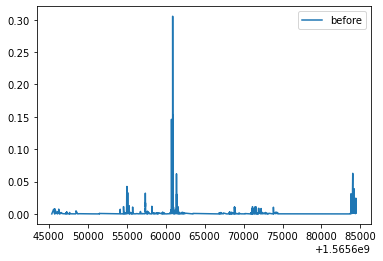

In [34]:

plt.plot(show_timestamp,show_originalV)

plt.legend(['before','corrected'])

# 변경 후 속도

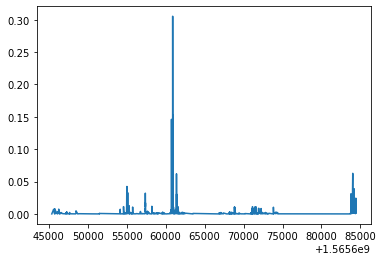

In [35]:

plt.plot(show_timestamp,show_correctedV)

# 고찰점

* timestamp  같은 경우의 데이터를 뺐습니다. <br>
* 오류라고 잡아내는 point의 상한선이 너무 높아서 데이터의 오류가 없는 것으로 나옵니다. 다시 한 번 확인 부탁드립니다. 

## 실제 오차율

In [36]:
for kk in range(len(data)):
    
    if data[kk]['longitudeCorrected']!=data[kk]['longitude']:
        print("longitudeCorrected: ")
    if data[kk]['latitudeCorrected']!=data[kk]['latitude']:
        print("latitudeCorrected: ")
    
    if data[kk]['originalV']!=data[kk]['correctedV']:
        print("vCorrected: ",str(kk))   
    if data[kk]['a']!=data[kk]['aCorrected']:
        print("aCorrected: ")   
    
    if data[kk]['filtered']=='true':
        print("filtered: "+str(kk))
    if data[kk]['accelFiltered']=='true':
        print("accelFiltered: "+str(kk))
    if data[kk]['retrieved']=='true':
          print("retrieved: "+str(kk))
    if data[kk]['interpolated']=='true':
        print("interpolate: "+str(kk))


longitudeCorrected: 
latitudeCorrected: 
vCorrected:  8
filtered: 8
retrieved: 8
interpolate: 8


#  수정사항
* MSD 와 MA 를 참고 문헌 공식을 사용하여 바꿀것  => 진짜 다봤는데 없다!(가장 그럴싸한것 ㅣ Algorithm for Discriminating the Signal from the Background to Search for Non-Naryonic Super-Symmetric Dark Matter)

* Vcalib 틀림 다시 할것 => 했음! 
* 파라미터를 json 으로 받아와 여러가지 파라미터에서 적용할 수 있게 할것=> 파라미터 여러 개 만듦 
*  timestamp 가 같은 경우 더 MSD 가 낮은 값 더 일반적인 데이터를 살리는 쪽으로 갈 것  => 귀차나

* 성용오빠의 data base 를 아예 받아올 수 있는 api 에서 사용하고 다시  수정된 값을 다른 테이블로 올려야한다.
* 그래프 더 많이 할것
* 위도와 경도 를 전후를 창준이에게 부탁해서 그림 그려달라고 할것



x=2
logn(e,x)

# 참고 문헌

In [37]:
28  MovingWindowDetectionforDiscreteData  => 이거 지금 나는 파일 구글링이 안됨.

SyntaxError: invalid syntax (<ipython-input-37-f5d01419b0e5>, line 1)

# json으로 변수 변환

In [38]:
#Initial Window Size 
IWS = 5
#Maximum Window Size, IWS <= MWS
MWS = 10
#min speed
MINSPEED = 2.00
#max acceleration
MAXaccel=10.8
#error tolerance of distantce
ET = 1.0
#user SL s
SL=0.95 

In [39]:
#Initial Window Size 
IWS = 5
#Maximum Window Size, IWS <= MWS
MWS = 10
#min speed
MINSPEED = 2.00
#max acceleration
MAXaccel=10.8
#error tolerance of distantce
ET = 1.0
#user SL s
SL=0.95 

In [40]:
# 논문에서 제공해 준 변수 항목들의 json
default_arguments={
    "IWS":5,
    "MWS":10,
    "MINSPEED":2.00,
    "MAXaccel":10.8,
    "ET":1.0,
    "SL":0.95
}
# Write JSON
with open('default_args.json', 'w', encoding="utf-8") as make_file:
    json.dump(default_arguments, make_file, ensure_ascii=False, indent="\t")
# Read JSON
with open('default_args.json', 'r', encoding="utf-8") as read_file:
    a=json.load(read_file)
    print(a['IWS'])

5


In [41]:
logn(e,0.005)

-5.298317366548036

In [42]:
# 논문에서 제공해 준 변수 항목들의 json
default_arguments={
    "IWS":5,
    "MWS":10,
    "MINSPEED":2.00,
    "MAXaccel":10.8,
    "ET":1.0,
    "SL":5.95
}
# Write JSON
with open('default_args100005.json', 'w', encoding="utf-8") as make_file:
    json.dump(default_arguments, make_file, ensure_ascii=False, indent="\t")